# Driver behavior mining

Driver behavior mining can be an interesting topic in telemetics area. If we can learn the subtle patterns from risky drivers, we are able to measure the risk level of a driver or a trip, and then apply some alerts to avoid potential crash or accidents.

### Industry Research

I first did some industry research and learnt from this paper, [What can we learn from telematics car driving data: A survey](https://www.sciencedirect.com/science/article/pii/S0167668722000233#fg0010), that accelerometer signals and car speed data can surface some patterns in driving behavors. The authors used a simple CNN model to predict whether part of  driving signals is associated with a known driver. They achieved some good results in this prediction, so it tells CNN is able to learn behavior patterns from individuals.

Sensor signals are temporal data. One of the most important characteristics in temporal data is every data point is a state and the next state can depend on previous states. It means the behavior a driver had at time step 10 is somehow a consequence of the behavior he/she did at time step 1. Just like a hard brake at 19:05:02 leads to the car to stop 3 seconds after. 

### How to learn this time dependent information from the data?

CNN is a good approach. In image classification, an image's RGB is segregated into 3 channels. Each pixel is connected as a sequence, and passed into CNN as training data. Accelerometer signals are similar to this. X, y, z are just red, green, and blue. The convolution layer and pool layer extract important underlying features from the sequence. After the training, CNN is able to extract the best features from the sequence in order to make a good prediction. This can be considered as a type of "aggregation" over time series. 


### Optimize the idea and build a baseline model

Here in this notebook, I replicated the idea from the paper but with different feature engineering techniques. 

The data the authors used only has speed signal, accelerometer signals on cars' movement direction, and the delta of direction change.

But we have speed, and all vertical (x), horizontal (y), and movement direction (z) accelerometer signals. 

I first created a dataset using 50 time steps as a window sample with these 4 signals as 4 channels. And I normalized these 4 features, trained a CNN, but ended up with a poor model. I think it was speed signal causing the poor performance. Because speed signals are high correlated with movement direction signals and speed is a discrete value which hides many subtle changes. 

Then I removed speed signal and trained a CNN with only accelerometer signals. The model performed a bit better, but it still not satisfying. The reason was just I used standard scaler to normalize these signals. They are actually already in a uniform unit. Signals are more or less noisy. Standard scaler based on mean and std will be impacted by outliers.

Finally, it sets a baseline at **93.6% F1 score** for predicting whether part of driving history is from a certain driver / device.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from numpy.lib.stride_tricks import as_strided

import tensorflow as tf
tf.random.set_seed(42)
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPool1D, GlobalMaxPooling1D
from keras.utils import np_utils

from sklearn.metrics import confusion_matrix

### Load aggregated accelerometer data

In [15]:
driving_df = pd.read_csv('aggregated_acc_signals.csv')

driving_df['timestamp'] = pd.to_datetime(driving_df['timestamp'])

driving_df.shape

(6660, 8)

In [16]:
driving_df.head()

,time_step,device_id,trip_id,timestamp,speed,acc_x,acc_y,acc_z
0,1,1,1,2018-01-24 19:48:02,2,-0.157700,0.044103,-0.986395
1,2,1,1,2018-01-24 19:48:03,0,-0.164984,0.062974,-0.994265
2,3,1,1,2018-01-24 19:48:04,0,-0.119859,0.030532,-0.996581
3,4,1,1,2018-01-24 19:48:05,0,-0.117717,0.056936,-0.996154
4,5,1,1,2018-01-24 19:48:06,2,-0.137219,0.070642,-0.986586


### Driving history 
By looking at the driving days of each device, we can see some of the days are close.

In [17]:
def device_driving_history(df):

    df['day_of_the_month'] = df['timestamp'].dt.day.astype(str)

    return df[['device_id', 'day_of_the_month']]\
        .drop_duplicates()\
        .groupby(['device_id'])\
        .agg({'day_of_the_month': lambda x: ', '.join(x.values)})

device_driving_history(driving_df.copy())

,day_of_the_month
device_id,
1,"24, 25"
3,"11, 21, 28, 31"
5,"10, 12, 19, 22"
6,31
7,"12, 18"
10,"1, 3, 9, 13, 19, 20, 28, 29, 30"
11,31


In [18]:
# driving_df = driving_df[~driving_df['device_id'].isin([6, 7, 1])] 

### Transform signals into window samples

We can apply a rolling window to the time steps for each trip. A window is a period of timestamps, or a list of row index in code. This helps us to easily extract samples for each window from the full driving history.

In [19]:
driving_df.head()

,time_step,device_id,trip_id,timestamp,speed,acc_x,acc_y,acc_z
0,1,1,1,2018-01-24 19:48:02,2,-0.157700,0.044103,-0.986395
1,2,1,1,2018-01-24 19:48:03,0,-0.164984,0.062974,-0.994265
2,3,1,1,2018-01-24 19:48:04,0,-0.119859,0.030532,-0.996581
3,4,1,1,2018-01-24 19:48:05,0,-0.117717,0.056936,-0.996154
4,5,1,1,2018-01-24 19:48:06,2,-0.137219,0.070642,-0.986586


In [20]:
driving_df[['device_id', 'trip_id', 'time_step']]

,device_id,trip_id,time_step
0,1,1,1
1,1,1,2
2,1,1,3
3,1,1,4
4,1,1,5
...,...,...,...
6655,11,9,563
6656,11,9,564
6657,11,9,565
6658,11,9,566


In [21]:
def windowed_view(arr, window, overlap):
    """ Apply rolling windows into the given array with an overlap
    """
    
    arr = np.asarray(arr)
    window_step = window - overlap
    new_shape = arr.shape[:-1] + ((arr.shape[-1] - overlap) // window_step, window)
    new_strides = (arr.strides[:-1] + (window_step * arr.strides[-1],) + arr.strides[-1:])
    
    return as_strided(arr, shape=new_shape, strides=new_strides)

In [22]:
def create_window_samples(df, window, overlap):
    """ Save all the row index of the rolling windows.
    """
    
    window_index_list = list()
    labels_list = list()
    
    for (device_id, trip_id), trip_df in df.groupby(['device_id', 'trip_id']):
#         print(trip_df)
        trip_length = trip_df.shape[0]
        window_index = windowed_view(trip_df.index, window, overlap)
        labels = np.full((window_index.shape[0], 1), device_id)
        window_index_list.append(window_index)
        labels_list.append(labels)

    return np.concatenate(window_index_list), np.concatenate(labels_list)

In [23]:
window_samples, labels = create_window_samples(driving_df, window=50, overlap=25)

In [24]:
window_samples

array([[   0,    1,    2, ...,   47,   48,   49],
       [  58,   59,   60, ...,  105,  106,  107],
       [  83,   84,   85, ...,  130,  131,  132],
       ...,
       [6543, 6544, 6545, ..., 6590, 6591, 6592],
       [6568, 6569, 6570, ..., 6615, 6616, 6617],
       [6593, 6594, 6595, ..., 6640, 6641, 6642]])

In [29]:
def extract_signals_per_window(df, window_samples, labels):
    """ Since the given window samples are a list of windows with row index. 
    We now need to use the index to extract signals from the driving history data.
    """
    
    signal_window_samples_list = list()
    
    for window, device_id in zip(window_samples, labels):
        
        # Standardize the speed and accelerometer signals
#         transformed_signals = StandardScaler().fit_transform(df.loc[window][['acc_x', 'acc_y', 'acc_z']])
        transformed_signals = df.loc[window][['acc_x', 'acc_y', 'acc_z']]
        signal_window_samples_list.append(transformed_signals)
    
    return np.asarray(signal_window_samples_list)

In [30]:
signal_window_samples = extract_signals_per_window(driving_df, window_samples, labels)

In [31]:
signal_window_samples.shape, labels.shape

((219, 50, 3), (219, 1))

In [32]:
pd.Series(labels.reshape(-1), name='labels').value_counts()

10    101
5      45
3      37
11     21
6       6
7       5
1       4
Name: labels, dtype: int64

In [33]:
X = signal_window_samples.copy()
y = labels.copy()

device_to_label = {category: i for i, category in enumerate(set(y.reshape(-1)))}
label_to_device = {i: category for i, category in enumerate(set(y.reshape(-1)))}
device_to_label

for device_id, label in device_to_label.items():
    y[y == device_id] = label

# Since the window samples are small, we should stratify on the device ids.
# This can make sure we have both training / test samples for each device id.
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.8, 
                                                    stratify=y, 
                                                    shuffle=True, 
                                                    random_state=42)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# one-hot encoding using keras' numpy-related utilities
n_classes = len(device_to_label)
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)

Shape before one-hot encoding:  (43, 1)
Shape after one-hot encoding:  (43, 7)


In [34]:
# building a linear stack of layers with the sequential model
model = Sequential()
# convolutional layer
model.add(Conv1D(filters=10, kernel_size=3, activation='tanh', input_shape=(50, 3)))
model.add(MaxPool1D(pool_size=3))

model.add(Conv1D(filters=8, kernel_size=3, activation='tanh'))
model.add(MaxPool1D(pool_size=3))

model.add(Conv1D(filters=4, kernel_size=3, activation='tanh'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.3))

model.add(Dense(n_classes, activation='softmax'))

# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

### Print out CNN Architecture

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 48, 10)            100       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 16, 10)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 14, 8)             248       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 4, 8)             0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 2, 4)              100       
                                                                 
 global_max_pooling1d (Globa  (None, 4)                0

### CNN Training logs

In [36]:
 model.fit(X_train, Y_train, batch_size=1, epochs=40, validation_data=(X_test, Y_test))

Epoch 1/40


2022-04-12 22:49:51.459473: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


43/43 [==============================] - 0s 4ms/step - loss: 1.9182 - accuracy: 0.2791 - val_loss: 1.8396 - val_accuracy: 0.2898
Epoch 2/40
43/43 [==============================] - 0s 2ms/step - loss: 1.8051 - accuracy: 0.3953 - val_loss: 1.7189 - val_accuracy: 0.7159
Epoch 3/40
43/43 [==============================] - 0s 2ms/step - loss: 1.6482 - accuracy: 0.6744 - val_loss: 1.6068 - val_accuracy: 0.4602
Epoch 4/40
43/43 [==============================] - 0s 2ms/step - loss: 1.5929 - accuracy: 0.5581 - val_loss: 1.5003 - val_accuracy: 0.4602
Epoch 5/40
43/43 [==============================] - 0s 2ms/step - loss: 1.4656 - accuracy: 0.5814 - val_loss: 1.3878 - val_accuracy: 0.5170
Epoch 6/40
43/43 [==============================] - 0s 2ms/step - loss: 1.3818 - accuracy: 0.6047 - val_loss: 1.2937 - val_accuracy: 0.6193
Epoch 7/40
43/43 [==============================] - 0s 2ms/step - loss: 1.2851 - accuracy: 0.6279 - val_loss: 1.1964 - val_accuracy: 0.6307
Epoch 8/40
43/43 [=============

In [37]:
Y_pred = model.predict(X_test)

### Model evaluation

Calculate recall and precision for each device id.

In the confusion matrix, we can see precision and recall for device 1, 6 and 7 are both 0. **It means the model didn't learn from these device samples.**

However, for **device 3, 5, 10 and 11**, they have enough data for the model to learn some subtle patterns. **The overall F1 score for them is 93.6%, which is relative good.** This sets a baseline for the further fine-tuning.

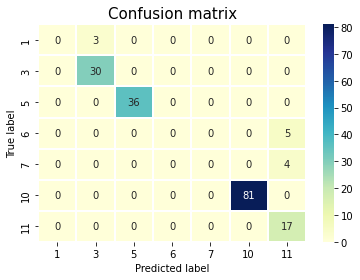

In [38]:
c_m = confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1))

fig = plt.figure()
labels = sorted(list(set(y.reshape(-1))))
device_ids = [label_to_device[l] for l in labels]
sns.heatmap(c_m, xticklabels=device_ids, yticklabels=device_ids, annot=True, 
            linewidths = 0.1, fmt="d", cmap = "YlGnBu")
plt.title("Confusion matrix", fontsize = 15)
plt.ylabel("True label")
plt.xlabel("Predicted label")
confusion_matrix_plot = fig

In [39]:
recall = np.diag(c_m) / np.sum(c_m, axis = 1)
precision = np.diag(c_m) / np.sum(c_m, axis = 0)
f1 = 2 * precision * recall / (precision + recall)

evaluation_df = pd.DataFrame({
    'device_id': device_ids,
    'recall': recall,
    'precision': precision,
    'f1': f1
}).set_index('device_id')

evaluation_df

/var/folders/wj/kg65sk251rz1g4h8_694mm9r0000gn/T/ipykernel_51488/3549722063.py:2: RuntimeWarning: invalid value encountered in true_divide
  precision = np.diag(c_m) / np.sum(c_m, axis = 0)


,recall,precision,f1
device_id,,,
1,0.0,NaN,NaN
3,1.0,0.909091,0.952381
5,1.0,1.000000,1.000000
6,0.0,NaN,NaN
7,0.0,NaN,NaN
10,1.0,1.000000,1.000000
11,1.0,0.653846,0.790698


In [40]:
print("Overall f1 score: {:,.3f}%".format(evaluation_df['f1'].mean()*100))

Overall f1 score: 93.577%
